In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
import math
import time
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [2]:
sns.set_style("whitegrid")
#sns.set_palette('Set1')

### Part 1: Data Pre-processing

In [3]:
df = pd.read_csv("../resources/data/discords/dutch_power/power_data.txt",header=None,names=['consumption'])

In [4]:
df.head()

,consumption
0,950
1,939
2,943
3,971
4,1014


In [5]:
num_values = "num_values: %s"%(df.shape[0])
print num_values

num_values: 35040


In [6]:
dates = pd.date_range('1/1/1997', periods=35040, freq='15Min')

In [7]:
df =df.set_index(dates)

In [8]:
df.head()

,consumption
1997-01-01 00:00:00,950
1997-01-01 00:15:00,939
1997-01-01 00:30:00,943
1997-01-01 00:45:00,971
1997-01-01 01:00:00,1014


In [9]:
df.tail()

,consumption
1997-12-31 22:45:00,622
1997-12-31 23:00:00,614
1997-12-31 23:15:00,627
1997-12-31 23:30:00,633
1997-12-31 23:45:00,882


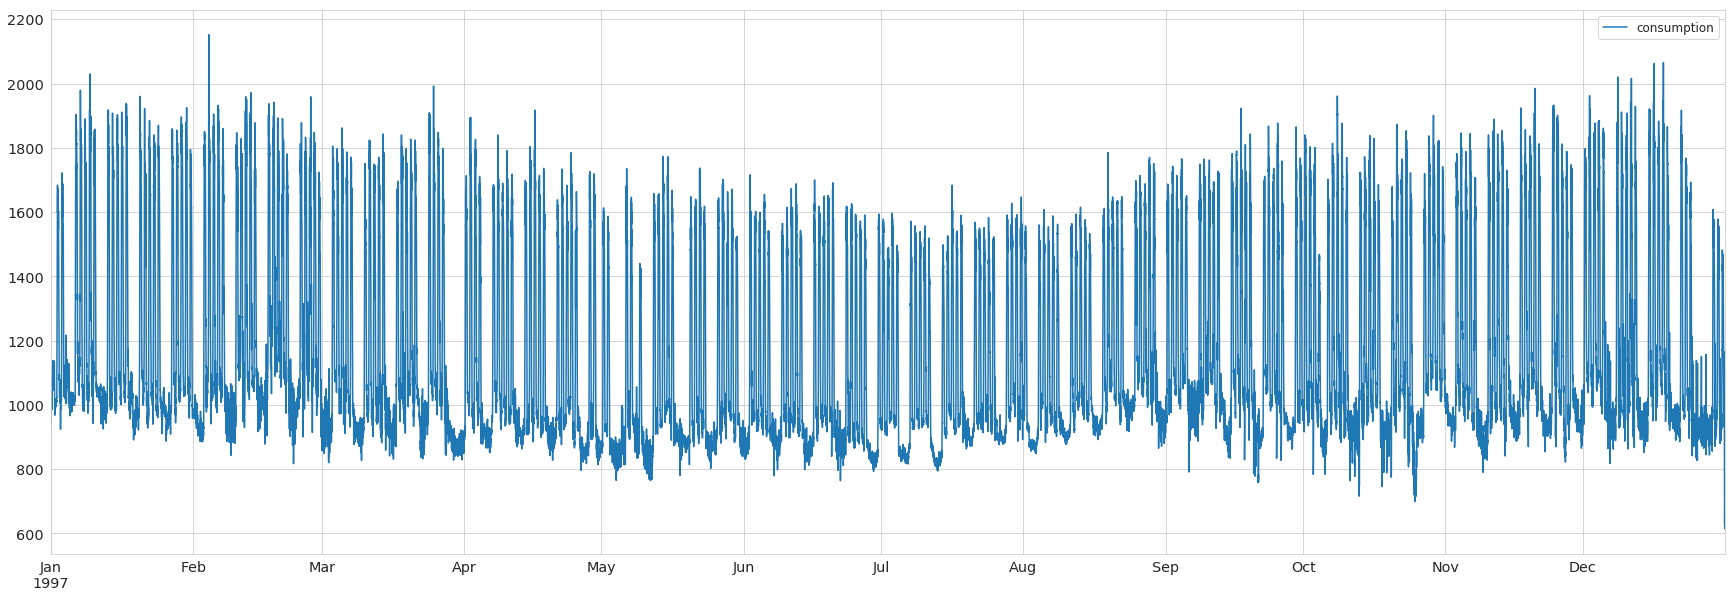

In [10]:
df.plot(figsize=(30,10))
plt.show()

In [11]:
# df = df.resample('1H').sum()
# df.head()

In [12]:
#df.tail()

In [11]:
#drop days from 1 to 5 jan to start from a monday.
df = df['1997-01-06':]
#add anomaly column
df['anomaly'] = 0
df.head()

,consumption,anomaly
1997-01-06 00:00:00,1008,0
1997-01-06 00:15:00,1001,0
1997-01-06 00:30:00,1009,0
1997-01-06 00:45:00,1009,0
1997-01-06 01:00:00,1001,0


In [12]:
df.tail()

,consumption,anomaly
1997-12-31 22:45:00,622,0
1997-12-31 23:00:00,614,0
1997-12-31 23:15:00,627,0
1997-12-31 23:30:00,633,0
1997-12-31 23:45:00,882,0


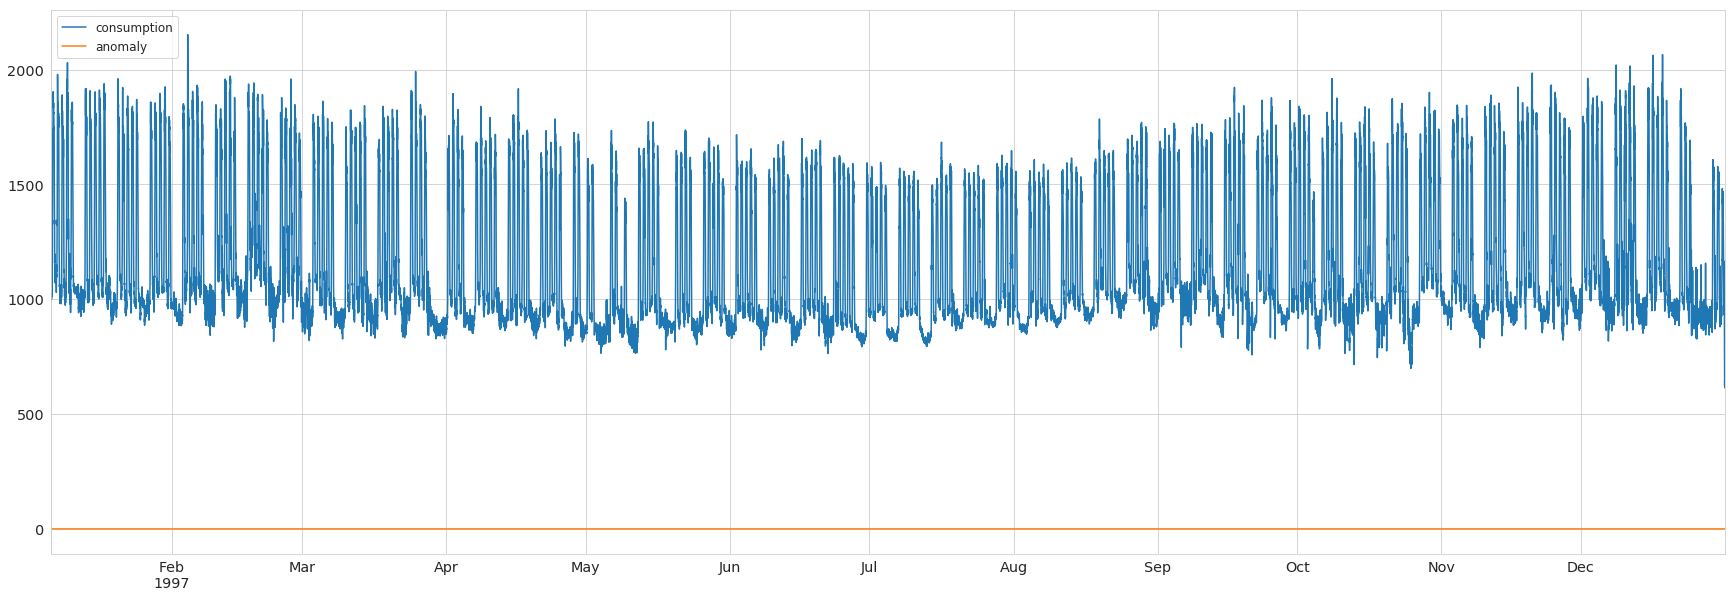

In [13]:
df.plot(figsize=(30,10))
plt.show()

In [16]:
#iterate over a week. a week will have 672 values
step = 672

# for i in range(0,df.shape[0],step):
#     fig = plt.figure(figsize=(15,5))
#     tmp = df[i:i+step]['consumption'].plot(color=sns.xkcd_rgb["denim blue"])
#     plt.title("week %s"%(i/step +1))
#     plt.xlabel('Time Stamp')
#     plt.ylabel('Power Consumption')
#     plt.show()
#     pp = PdfPages("power_week_%s.pdf"%(i/step +1))
#     pp.savefig(fig)
#     pp.close()
    

In [19]:
anomaly_weeks = [12,13,17,18,20,39,51,52]
validation1_weeks = [2,4,14]
validation2_weeks = [10,11,12,13,19,20,38,39]
test_weeks = [15,16,17,18,50,51,52]

df_train_list = []
df_valid1_list = []
df_valid2_list = []
df_test_list = []

for i in range(0,df.shape[0],step):
    #df[i:i+step].plot(figsize=(30,10))
    week = i/step +1
    if week in validation1_weeks:
        df_valid1_list.append(df[i:i+step])  
    elif week in validation2_weeks:
        if week in anomaly_weeks:
            df[i:i+step]['anomaly'] =1
        df_valid2_list.append(df[i:i+step])
    elif week in test_weeks:
        if week in anomaly_weeks:
            df[i:i+step]['anomaly'] =1
        df_test_list.append(df[i:i+step])
    else:
        df_train_list.append(df[i:i+step])

print len(df_train_list)
print len(df_valid1_list)
print len(df_valid2_list)
print len(df_test_list)
   

34
3
8
7


/home/duys/Documents/machine_learning/lstm_anomaly_thesis/lstm/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/duys/Documents/machine_learning/lstm_anomaly_thesis/lstm/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
df_validation1 = pd.concat(df_valid1_list)
df_validation2 = pd.concat(df_valid2_list)
df_dict = {}
df_dict['train'] = df_train
df_dict['test'] = df_test
df_dict['validation1'] = df_validation1
df_dict['validation2'] = df_validation2

In [22]:
df_dict['validation2']

,consumption,anomaly
1997-03-10 00:00:00,944,0
1997-03-10 00:15:00,930,0
1997-03-10 00:30:00,917,0
1997-03-10 00:45:00,900,0
1997-03-10 01:00:00,904,0
1997-03-10 01:15:00,921,0
1997-03-10 01:30:00,936,0
1997-03-10 01:45:00,933,0
1997-03-10 02:00:00,940,0
1997-03-10 02:15:00,934,0


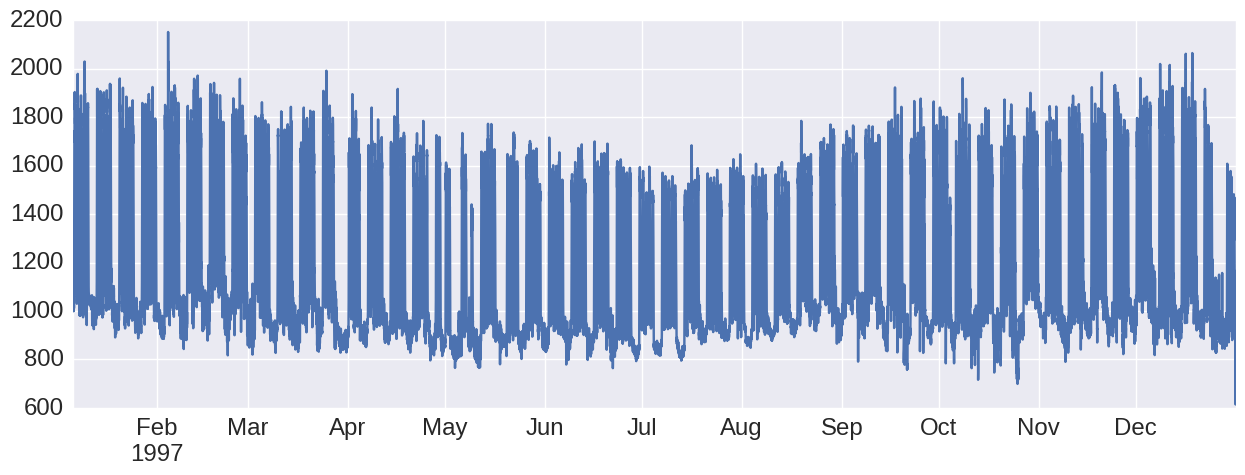

In [32]:
plt.figure()
df['consumption'].plot(figsize=(15,5))
rows = df[df.anomaly.isin([1])].itertuples()
for row in rows:
    plt.plot(row[0], row[1], 'r.', markersize=5.0)
plt.show()

Size of test: 4320
Size of validation1: 2016
Size of validation2: 5376
Size of train: 22848
Total: 34560
Ratio of test: 0.125000
Ratio of validation1: 0.058333
Ratio of validation2: 0.155556
Ratio of train: 0.661111


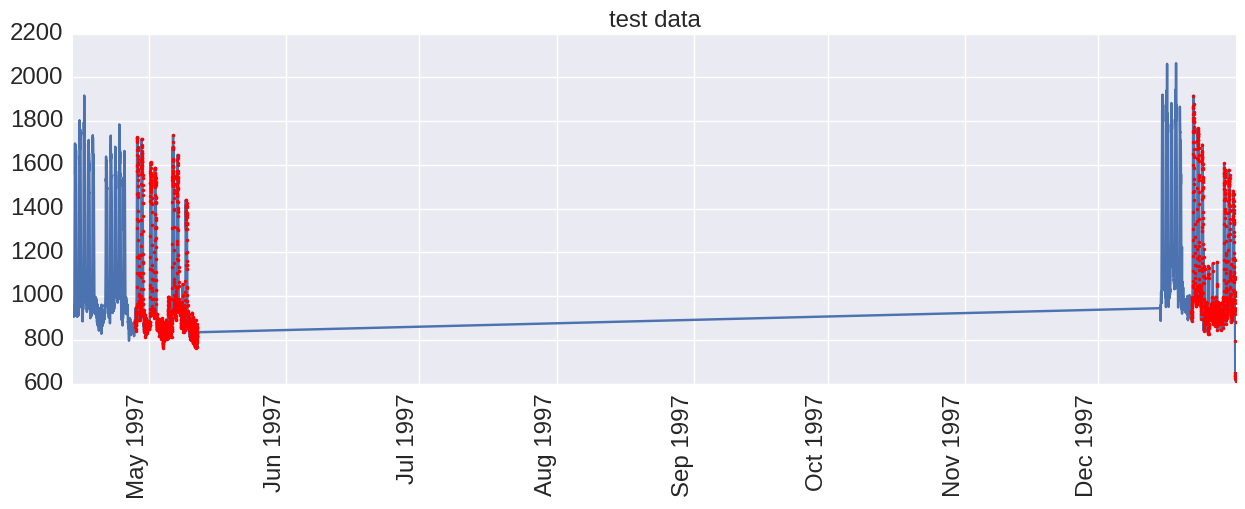

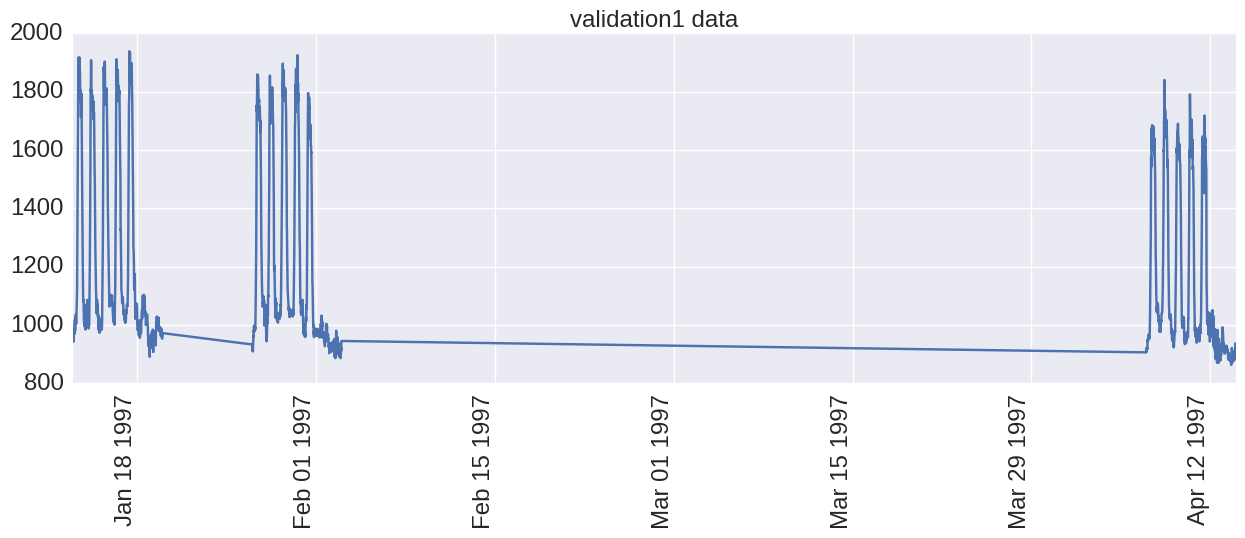

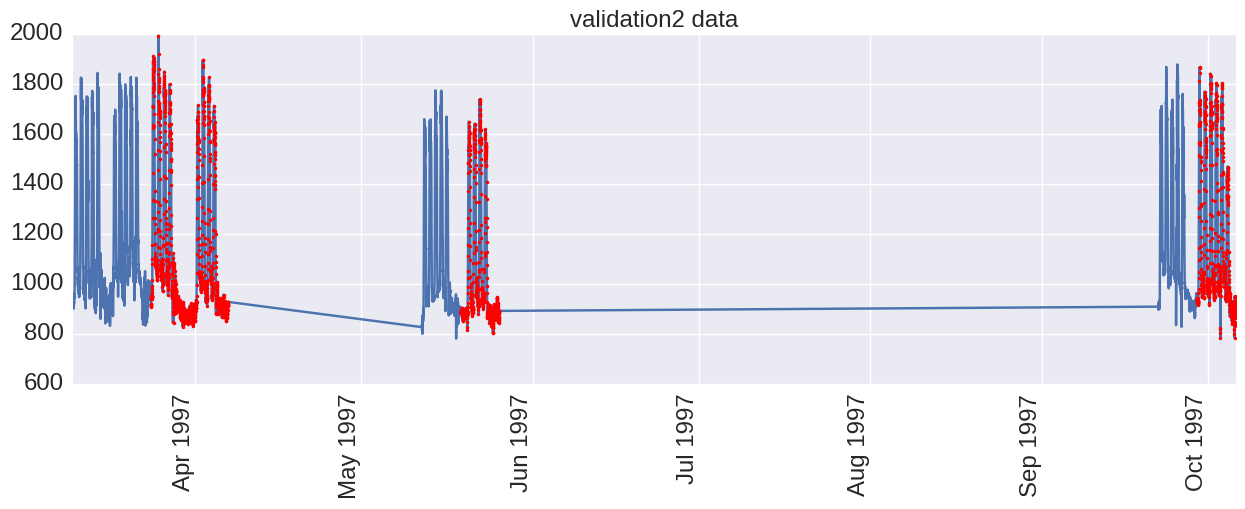

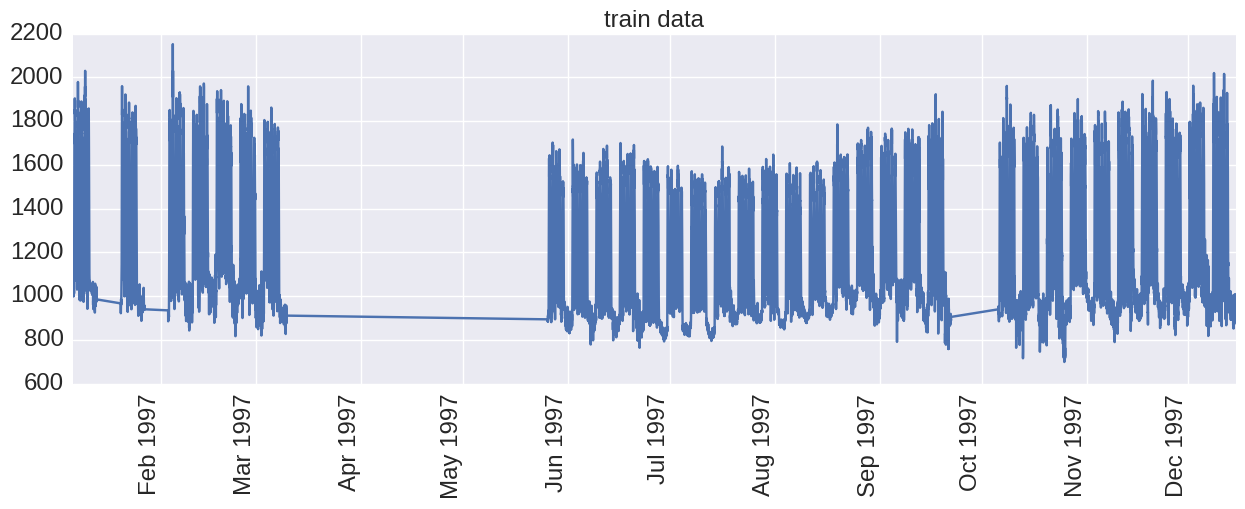

In [33]:
count = 0
for key in df_dict:
    print "Size of %s: %d"%(key,df_dict[key].shape[0])
    count += df_dict[key].shape[0]
print "Total: %d"%(count)

for key in df_dict:
    print "Ratio of %s: %f"%(key,float(df_dict[key].shape[0])/count)

for key in df_dict:
    plt.figure()
    df_tmp = df_dict[key]
    df_tmp['consumption'].plot(figsize=(15,5))
    rows = df_tmp[df_tmp.anomaly.isin([1])].itertuples()
    for row in rows:
        plt.plot(row[0], row[1], 'r.', markersize=5.0)
    plt.xticks(rotation='vertical')
    plt.title("%s data"%(key))
    plt.show()

In [34]:
for key in df_dict:
    np.save("../resources/data/discords/dutch_power/%s"%(key),df_dict[key])

### Part 2: Prediction Modeling
Use python scripts: *lstm_predictor.py , stateful_lstm_predictor.py*.

### Part 3: Anomaly Detection

In [82]:
data_folder = "../resources/data/discords/dutch_power/"

In [83]:
#load training data
train_predictions = np.load(data_folder+"train_predictions.npy")
train_true = np.load(data_folder+"train_true.npy")
print train_predictions.shape
print train_true.shape


(22814, 1)
(22814,)


In [84]:
#load validation2 data
validation2_predictions = np.load(data_folder+"validation2_predictions.npy")
validation2_true = np.load(data_folder+"validation2_true.npy")
validation2_labels = np.load(data_folder+"validation2_labels.npy")
print np.shape(validation2_predictions)
print np.shape(validation2_true)
print np.shape(validation2_labels)
validation2_labels = np.reshape(validation2_labels,[len(validation2_labels),np.shape(validation2_labels)[1]])
print np.shape(validation2_labels)


(5368, 1)
(5368,)
(5374, 1, 1)
(5374, 1)


In [85]:
# load test data
test_predictions = np.load(data_folder+"test_predictions.npy")
test_true = np.load(data_folder+"test_true.npy")
test_labels = np.load(data_folder+"test_labels.npy")
print np.shape(test_predictions)
print np.shape(test_true)
test_labels = np.reshape(test_labels,[len(test_labels),np.shape(test_labels)[1]])
print np.shape(test_labels)

(4026, 1)
(4026,)
(4318, 1)


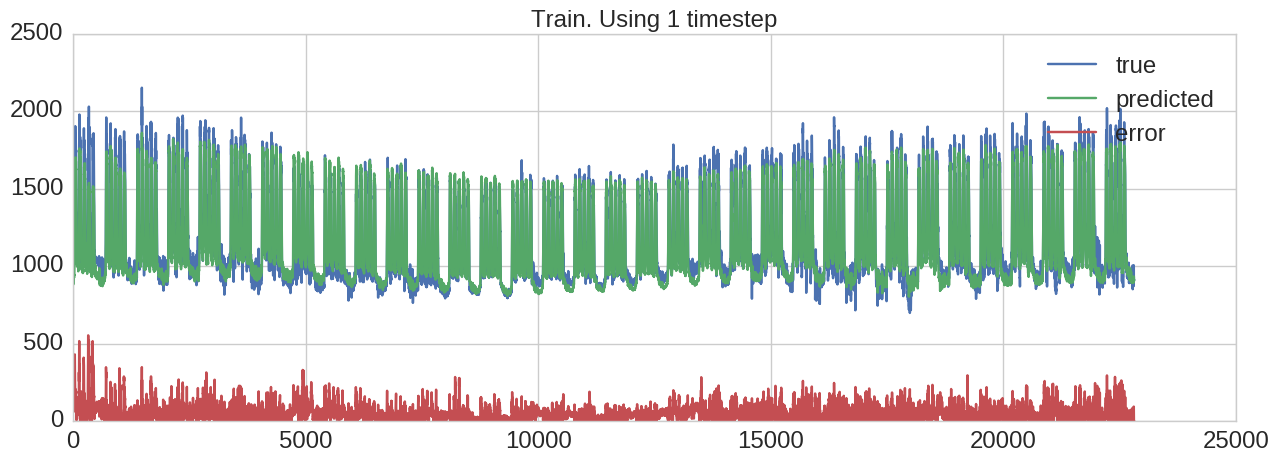

In [86]:
plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.legend()
plt.title("Train. Using 1 timestep")
plt.show()

[ 9.67527837]
5004.23502961


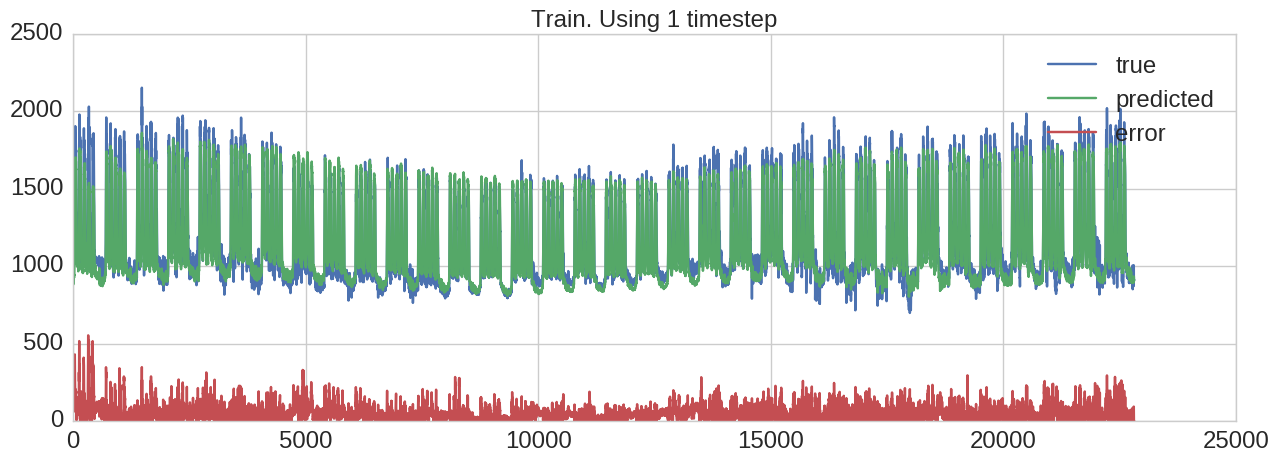

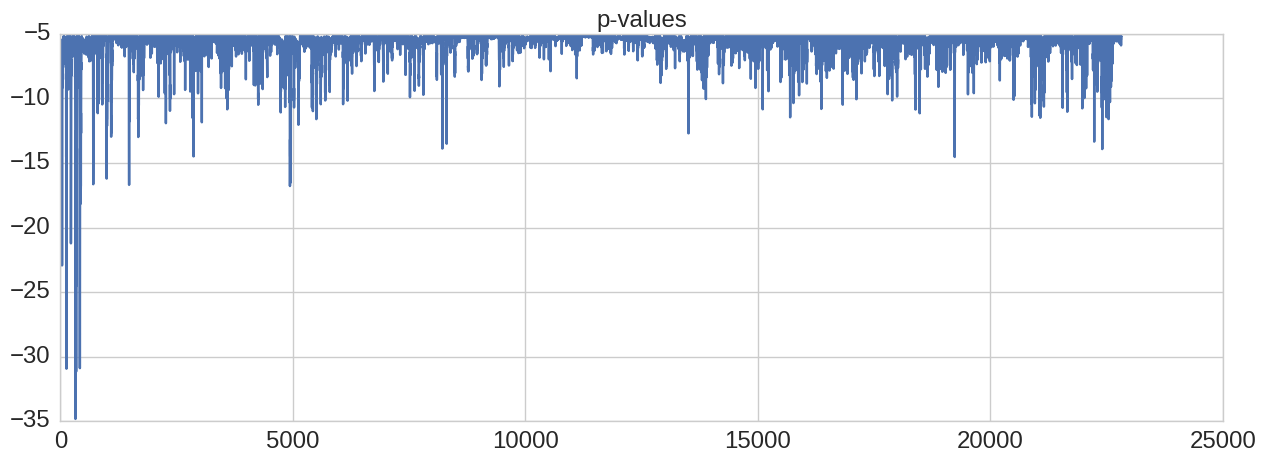

In [87]:
#error vectors
from scipy.stats import norm
from scipy.stats import multivariate_normal

train_error_vectors = np.zeros(np.shape(train_predictions))
n_cols = np.shape(train_predictions)[1]
for i in range(n_cols):
    train_error_vectors[:,i] =  train_true -train_predictions[:,i]

mean = np.mean(train_error_vectors, axis=0)
cov = np.cov(train_error_vectors,rowvar=False)
print mean
print cov
p_values= multivariate_normal.logpdf(train_error_vectors,mean,cov)

plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.title("Train. Using 1 timestep")
plt.legend()

# plt.figure(figsize=(15,5))
# plt.plot(train_true,label='true')
# plt.plot(train_predictions[:,5],label='predicted')
# plt.plot(abs(train_true - train_predictions[:,5]),label='error')
# plt.title("Train. Using 6 timestep")
# plt.legend()

plt.figure(figsize=(15,5))
plt.plot(p_values)
plt.title("p-values")
plt.show()

train_errors_1 = train_true - train_predictions[:,0]

In [88]:
v2_error_vectors = np.zeros(np.shape(validation2_predictions))
for i in range(n_cols):
    v2_error_vectors[:,i] =  validation2_true -validation2_predictions[:,i]
v2_p_values= multivariate_normal.logpdf( v2_error_vectors,mean,cov)
# v2_true_anomalies = np.where(validation2_labels[:,0]==1)
# print "Validation2. Number True Anomalies: %d"%(np.shape(v2_true_anomalies)[1])
# print "Validation2. Location of anomalies: %s"%(v2_true_anomalies)
# print "validation2. True anomalies: %s"%(validation2_true[v2_true_anomalies])
# v2_thresholds =v2_p_values[v2_true_anomalies]
# print "validation2. p-values at true anomalies: %s"%(v2_thresholds)

print 
test_error_vectors = np.zeros(np.shape(test_predictions))
for i in range(n_cols):
    test_error_vectors[:,i] =  test_true -test_predictions[:,i]
test_p_values= multivariate_normal.logpdf( test_error_vectors,mean,cov)
test_true_anomalies = np.where(test_labels[:,0]==1)
# print "Test. Number True Anomalies in: %d"%(np.shape(test_true_anomalies)[1])
# print "Test. Location of anomalies: %s"%(test_true_anomalies)
# print "Test. True anomalies: %s"%(test_true[test_true_anomalies])
# test_thresholds = test_p_values[test_true_anomalies]
# print "Test. p-values at true anomalies: %s"%(test_thresholds)




In [89]:
 #print pylab.rcParams.keys()

In [90]:
# #plot v2 predictions
# plt.figure()
# plt.plot(validation2_true,label='True Value',color=sns.xkcd_rgb["denim blue"])
# plt.plot(validation2_predictions[:,0],ls ='dashed',label='Predicted Value',color=sns.xkcd_rgb["medium green"])
# plt.plot(abs(validation2_true - validation2_predictions[:,0]),label='Error',color=sns.xkcd_rgb["pale red"])
# #for row in v2_true_anomalies:
# #    plt.plot(row, validation2_true[row], 'r.', markersize=20.0)
# plt.legend(bbox_to_anchor=(1,.37),borderaxespad=0.)
# plt.xlabel("Time step")
# plt.ylabel("Power Consumption")
# #plt.title("Validation2. Using 1 timestep")
# plt.show()

# #plot v2 log PD
# plt.figure()
# plt.plot(v2_p_values,label='Log PD',color=sns.xkcd_rgb["dark teal"])
# plt.axhline(y=threshold_v2,ls='dashed',label='Threshold',color=sns.xkcd_rgb["dark teal"])
# plt.legend(bbox_to_anchor=(1, .45), borderaxespad=0.)
# plt.xlabel("Time step")
# plt.ylabel("Log PD")
# #plt.title("Validation2 p-values")
# plt.show()


[1761 1762 1764 1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776
 1777 1778 1779 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791
 1792 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077
 2078 2079 2080 2081 3395 3396 3397 3398 3399 3400 3401 3402 3403 3404 3405
 3406 3407 3408 3409 3410 3411 3412 3413 3414 3415 3416 3417 3418 5233]


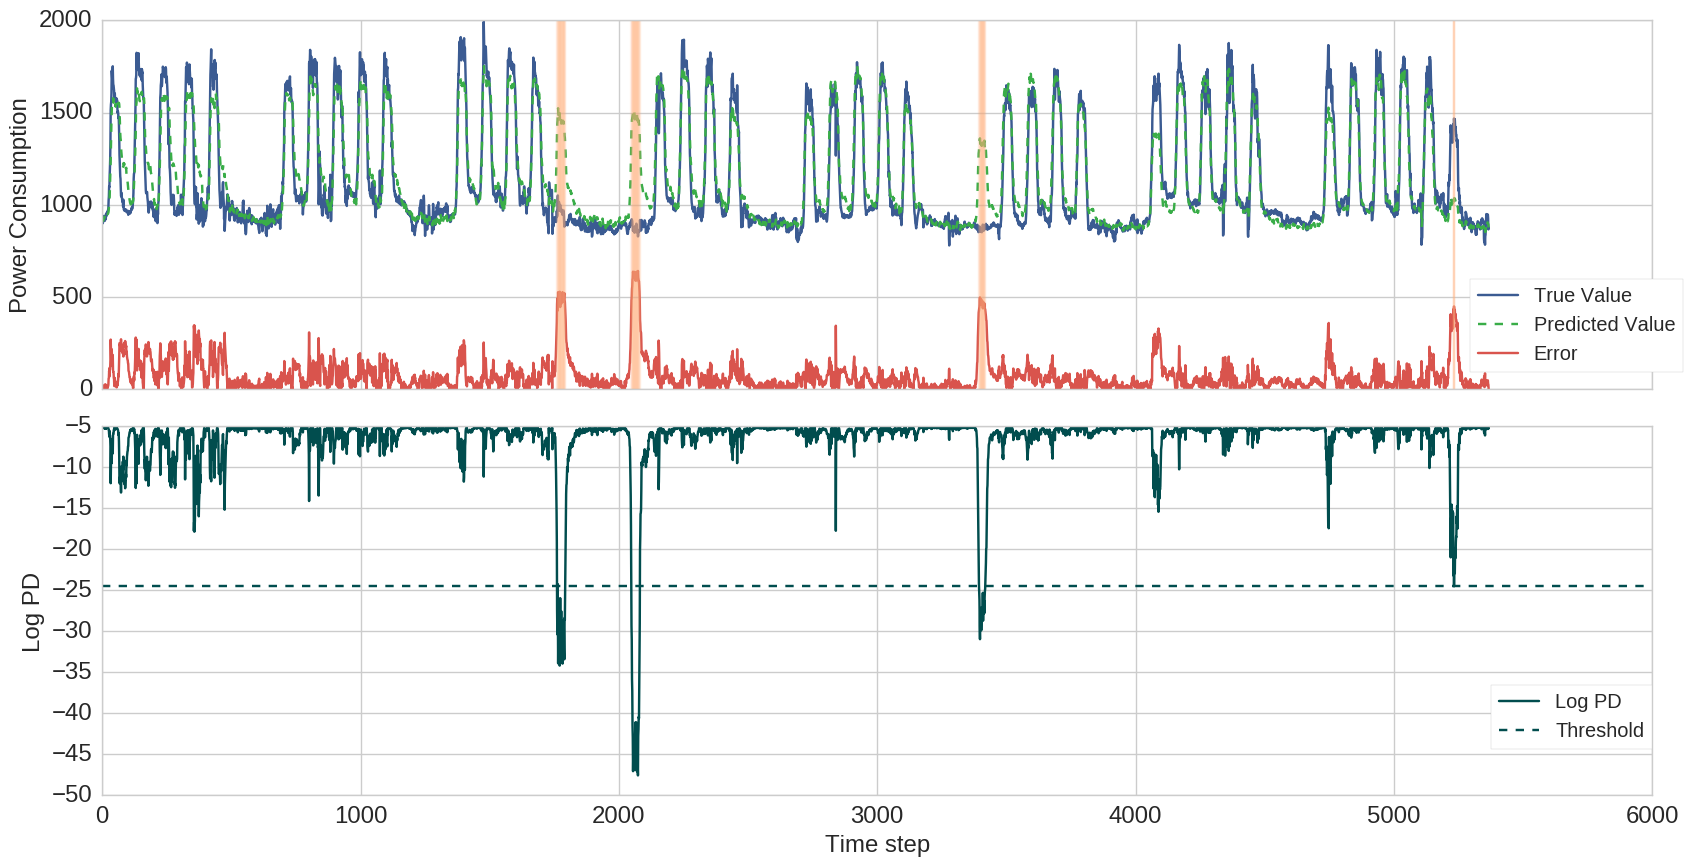

In [112]:
threshold_v2 = -24.5

f = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.1)

v2_below_threshold = np.where(v2_p_values <= threshold_v2)
ax1 = plt.subplot(211)
ax1.plot(validation2_true,label='True Value',color=sns.xkcd_rgb["denim blue"])
ax1.plot(validation2_predictions[:,0],ls ='dashed',label='Predicted Value',color=sns.xkcd_rgb["medium green"])
ax1.plot(abs(validation2_true - validation2_predictions[:,0]),label='Error',color=sns.xkcd_rgb["pale red"])
for column in v2_below_threshold[0]:
    ax1.axvline(x=column,color=sns.xkcd_rgb["peach"],alpha=.1)
print v2_below_threshold[0]
ax1.axvline(x=v2_below_threshold[0][-1],color=sns.xkcd_rgb["peach"],alpha=.5)
#for row in v2_true_anomalies:
#    plt.plot(row, validation2_true[row], 'r.', markersize=20.0)
ax1.legend(bbox_to_anchor=(1.02,.3),borderaxespad=0.,frameon=True)
plt.ylabel("Power Consumption")
#plt.title("Validation2. Using 1 timestep")


#plot v2 log PD
ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(v2_p_values,label='Log PD',color=sns.xkcd_rgb["dark teal"])
ax2.axhline(y=threshold_v2,ls='dashed',label='Threshold',color=sns.xkcd_rgb["dark teal"])
ax2.legend(bbox_to_anchor=(1, .3), borderaxespad=0.,frameon=True)
plt.ylabel("Log PD")
#plt.title("Validation2 p-values")

#Set up the xlabel and xtick
#xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlabel("Time step")
plt.show()
pp = PdfPages('power_v2.pdf')
pp.savefig(f)
pp.close()

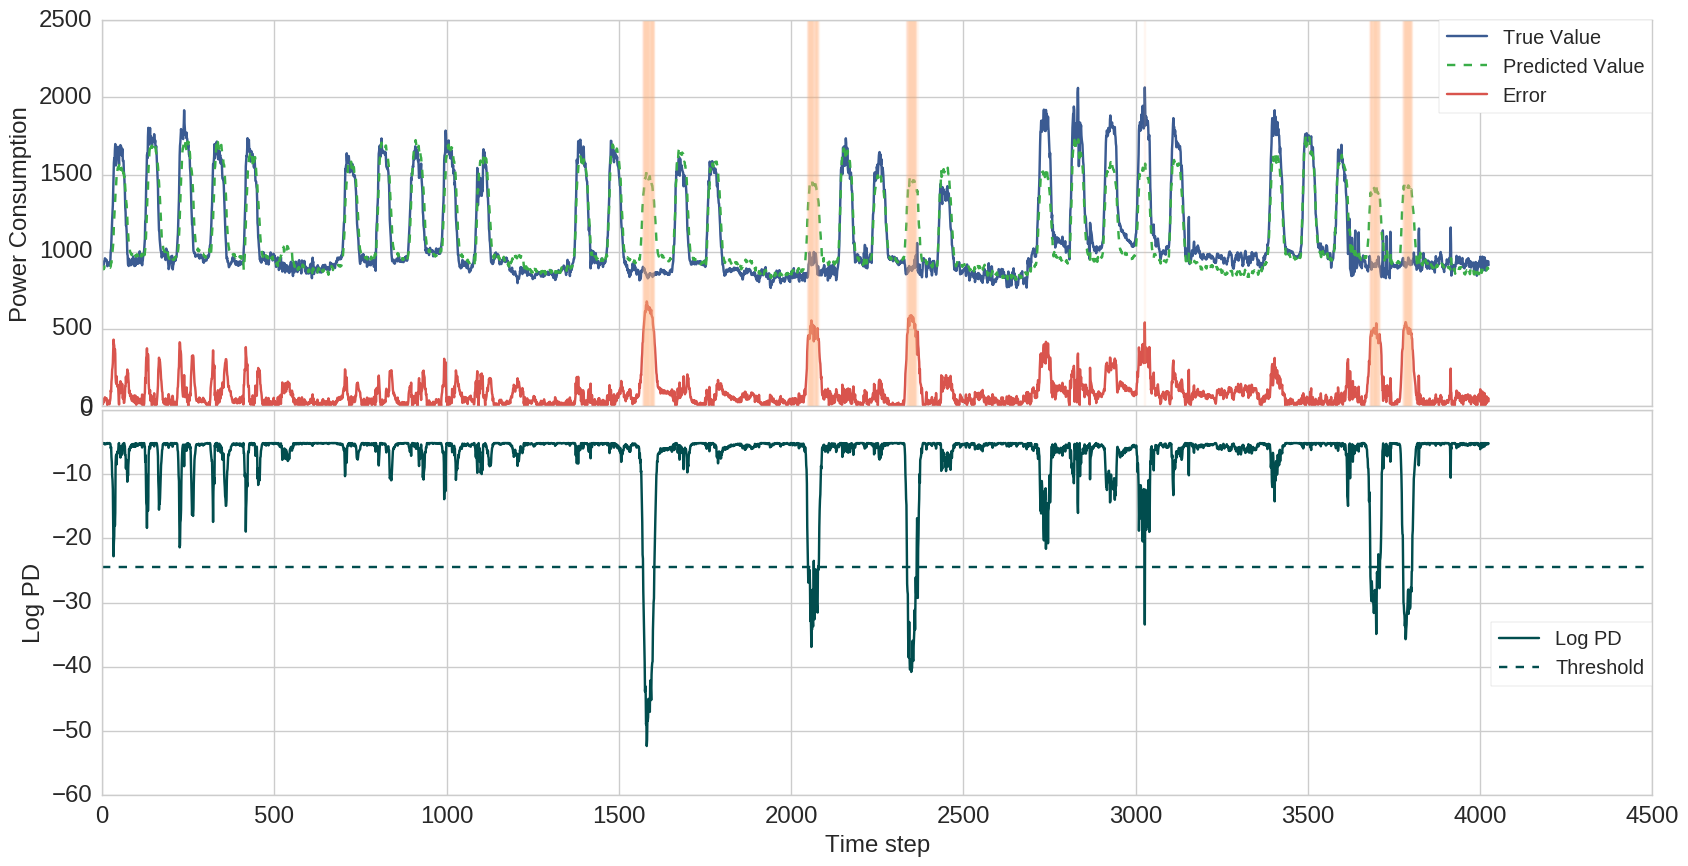

In [113]:
test_below_threshold = np.where(test_p_values <= threshold_v2)
#plot test data
f = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.01)

ax1 = plt.subplot(211)
ax1.plot(test_true,label='True Value',color=sns.xkcd_rgb["denim blue"])
ax1.plot(test_predictions[:,0],ls ='dashed',label='Predicted Value',color=sns.xkcd_rgb["medium green"])
ax1.plot(abs(test_true - test_predictions[:,0]),label='Error',color=sns.xkcd_rgb["pale red"])
for column in test_below_threshold[0]:
    ax1.axvline(x=column,color=sns.xkcd_rgb["peach"],alpha=0.1)
#for row in test_true_anomalies:
#    plt.plot(row, test_true[row], 'r.', markersize=20.0)
ax1.legend(bbox_to_anchor=(1, 1), borderaxespad=0.,frameon=True)
plt.ylabel("Power Consumption")
#plt.title("Test. Using 1 timestep")

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(test_p_values,label='Log PD',color=sns.xkcd_rgb["dark teal"])
ax2.axhline(y=threshold_v2,ls='dashed',label='Threshold',color=sns.xkcd_rgb["dark teal"])
ax2.legend(bbox_to_anchor=(1, .45), borderaxespad=0.,frameon=True)
plt.ylabel("Log PD")
#plt.title("test p-values")

#Set up the xlabel and xtick
#xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlabel("Time step")
plt.show()
pp = PdfPages('power_test.pdf')
pp.savefig(f)
pp.close()